All imports successful!
STACKING/BLENDING ENSEMBLE FOR RECOMMENDER SYSTEMS

1. Generating recommendation data...
Dataset shape: (5000, 12)

Columns: ['user_id', 'item_id', 'user_age', 'user_gender', 'item_category', 'item_price', 'item_rating', 'user_activity', 'time_of_day', 'day_of_week', 'click', 'rating']

Click distribution: {False: 3951, True: 1049}
Rating statistics: min=1.00, max=4.24, mean=2.44

2. Preparing data...
Features shape: (5000, 13)
Classification target shape: (5000,)
Regression target shape: (5000,)

3. Splitting data...
Train shape: (3500, 13)
Test shape: (1500, 13)

4. Scaling features...

CLASSIFICATION TASK: CLICK PREDICTION

TRAINING RANDOM_FOREST_CLASSIFICATION

Results for random_forest_classification:
  Train Accuracy: 0.8031
  Test Accuracy: 0.8040
  Train AUC: 0.8197
  Test AUC: 0.7432

TRAINING LOGISTIC_CLASSIFICATION

Results for logistic_classification:
  Train Accuracy: 0.8100
  Test Accuracy: 0.8247
  Train AUC: 0.7395
  Test AUC: 0.7478

TRAINING XG

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

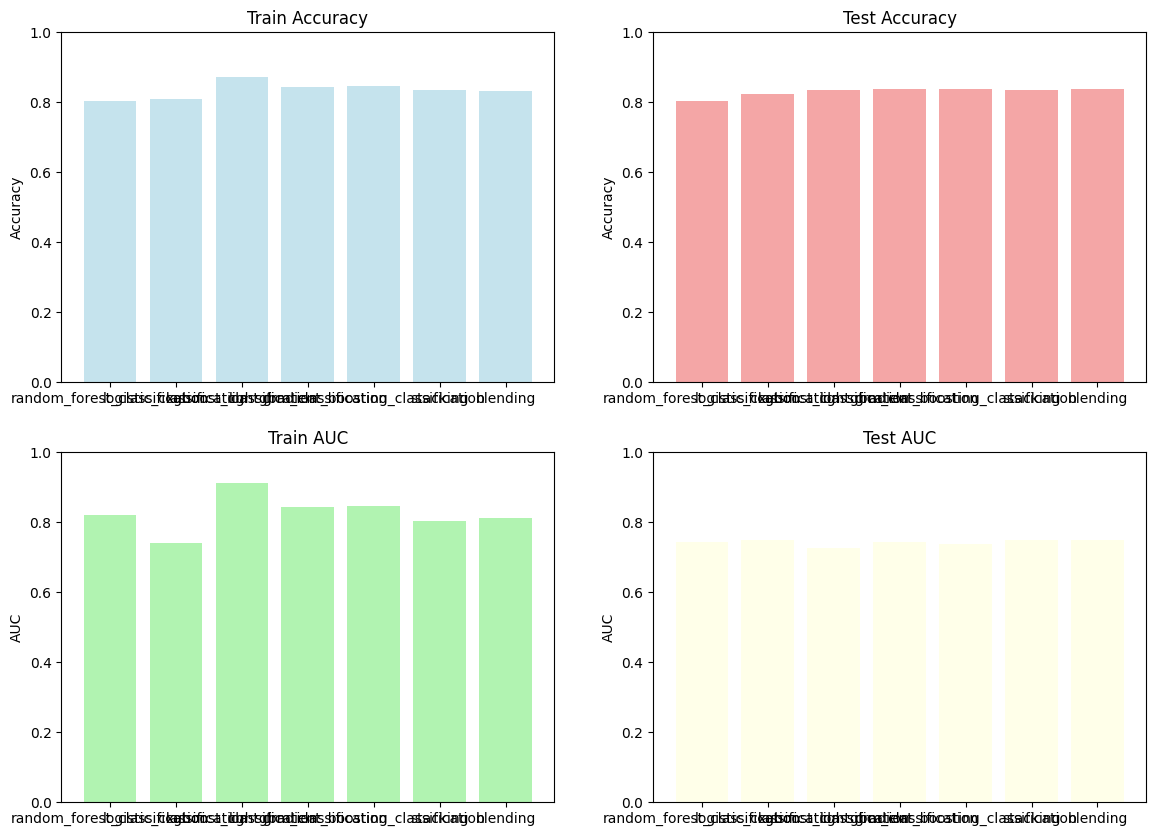

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Union, Callable
import warnings
warnings.filterwarnings('ignore')

print("All imports successful!")

# ============================================
# 1. ГЕНЕРАЦИЯ ДАННЫХ
# ============================================

def generate_recommendation_data(n_samples=10000, n_users=1000, n_items=500):
    """Генерация данных для рекомендательной системы"""
    np.random.seed(42)

    # Базовые данные
    data = {
        'user_id': np.random.randint(1, n_users + 1, n_samples),
        'item_id': np.random.randint(1, n_items + 1, n_samples),
        'user_age': np.random.randint(18, 65, n_samples),
        'user_gender': np.random.choice(['M', 'F'], n_samples, p=[0.55, 0.45]),
        'item_category': np.random.choice(['electronics', 'books', 'clothing', 'home', 'sports'], n_samples),
        'item_price': np.random.uniform(5, 500, n_samples),
        'item_rating': np.random.uniform(1, 5, n_samples),
        'user_activity': np.random.randint(1, 100, n_samples),
        'time_of_day': np.random.randint(0, 24, n_samples),
        'day_of_week': np.random.randint(0, 7, n_samples),
    }

    df = pd.DataFrame(data)

    # Создаем сложную целевую переменную
    # Симулируем взаимодействия пользователь-товар
    interaction_score = (
        0.3 * (df['user_age'] / 65) +
        0.2 * (df['item_rating'] / 5) +
        0.1 * (np.sin(df['time_of_day'] / 24 * 2 * np.pi)) +
        0.1 * (df['user_activity'] / 100) +
        0.3 * np.random.normal(0, 0.2, n_samples)
    )

    # Бинарная цель (клик/нет клика)
    df['click'] = (interaction_score > 0.5).astype(int)

    # Регрессионная цель (рейтинг)
    df['rating'] = np.clip(interaction_score * 4 + 1, 1, 5)

    # Добавляем шум
    df['click'] = df['click'] ^ (np.random.random(n_samples) < 0.1)
    df['rating'] = df['rating'] + np.random.normal(0, 0.3, n_samples)
    df['rating'] = np.clip(df['rating'], 1, 5)

    return df

# ============================================
# 2. БАЗОВЫЕ МОДЕЛИ
# ============================================

class BaseModel:
    """Базовый класс для моделей в stacking"""

    def __init__(self, model_type='random_forest', task='classification'):
        self.model_type = model_type
        self.task = task
        self.model = self._create_model()
        self.is_fitted = False

    def _create_model(self):
        """Создание модели в зависимости от типа"""
        if self.task == 'classification':
            if self.model_type == 'random_forest':
                return RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
            elif self.model_type == 'logistic':
                return LogisticRegression(random_state=42, max_iter=1000)
            elif self.model_type == 'svm':
                return SVC(probability=True, random_state=42, kernel='linear')
            elif self.model_type == 'knn':
                return KNeighborsClassifier(n_neighbors=5)
            elif self.model_type == 'xgboost':
                return XGBClassifier(n_estimators=100, random_state=42, max_depth=3)
            elif self.model_type == 'lightgbm':
                return LGBMClassifier(n_estimators=100, random_state=42, max_depth=3)
            elif self.model_type == 'gradient_boosting':
                return GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
            else:
                raise ValueError(f"Unknown model type: {self.model_type}")
        else:  # regression
            if self.model_type == 'random_forest':
                return RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
            elif self.model_type == 'ridge':
                return Ridge(random_state=42)
            else:
                raise ValueError(f"Unknown model type for regression: {self.model_type}")

    def fit(self, X, y):
        """Обучение модели"""
        self.model.fit(X, y)
        self.is_fitted = True
        return self

    def predict(self, X):
        """Предсказание"""
        if not self.is_fitted:
            raise ValueError("Model is not fitted yet!")

        if self.task == 'classification':
            return self.model.predict_proba(X)[:, 1]
        else:
            return self.model.predict(X)

    def get_name(self):
        """Получение имени модели"""
        return f"{self.model_type}_{self.task}"

# ============================================
# 3. STACKING РЕАЛИЗАЦИЯ
# ============================================

class StackingEnsemble:
    """
    Stacking ансамбль для рекомендательных систем
    """

    def __init__(self, base_models: List[BaseModel], meta_model: BaseModel,
                 n_folds: int = 5, use_probas: bool = True, random_state: int = 42):
        """
        Args:
            base_models: список базовых моделей
            meta_model: мета-модель
            n_folds: количество фолдов для out-of-fold предсказаний
            use_probas: использовать вероятности (для классификации) или предсказания
            random_state: случайное seed
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.use_probas = use_probas
        self.random_state = random_state
        self.is_fitted = False
        self.base_models_trained = []
        self.meta_features_train = None
        self.meta_features_test = None

    def _create_meta_features(self, X: np.ndarray, y: np.ndarray,
                            X_test: np.ndarray = None, mode: str = 'train') -> Tuple[np.ndarray, np.ndarray]:
        """
        Создание мета-признаков через out-of-fold предсказания

        Args:
            X: обучающие данные
            y: целевая переменная
            X_test: тестовые данные (для режима predict)
            mode: 'train' или 'predict'
        """
        if mode == 'train':
            n_samples = X.shape[0]
            n_base_models = len(self.base_models)

            # Инициализируем массив для мета-признаков
            meta_features = np.zeros((n_samples, n_base_models))

            # Стратифицированные фолды для классификации, обычные для регрессии
            if self.base_models[0].task == 'classification':
                kf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
                splits = kf.split(X, y)
            else:
                kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
                splits = kf.split(X)

            print(f"Creating meta-features with {self.n_folds} folds...")

            for fold_idx, (train_idx, val_idx) in enumerate(splits):
                print(f"  Processing fold {fold_idx + 1}/{self.n_folds}")

                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold = y[train_idx]

                # Обучаем каждую базовую модель на фолде
                for model_idx, base_model in enumerate(self.base_models):
                    # Создаем копию модели для каждого фолда
                    model_copy = BaseModel(base_model.model_type, base_model.task)

                    # Обучаем на train части фолда
                    model_copy.fit(X_train_fold, y_train_fold)

                    # Предсказываем на validation части
                    if self.use_probas and base_model.task == 'classification':
                        # Используем вероятность положительного класса
                        preds = model_copy.predict(X_val_fold)
                        meta_features[val_idx, model_idx] = preds
                    else:
                        # Используем обычные предсказания
                        if base_model.task == 'classification':
                            preds = model_copy.model.predict_proba(X_val_fold)[:, 1]
                        else:
                            preds = model_copy.model.predict(X_val_fold)
                        meta_features[val_idx, model_idx] = preds

            # Обучаем финальные версии базовых моделей на всех данных
            print("\nTraining final base models on full training data...")
            self.base_models_trained = []
            for model_idx, base_model in enumerate(self.base_models):
                print(f"  Training {base_model.get_name()}...")
                model_final = BaseModel(base_model.model_type, base_model.task)
                model_final.fit(X, y)
                self.base_models_trained.append(model_final)

            return meta_features, None

        else:  # mode == 'predict'
            n_test_samples = X_test.shape[0]
            n_base_models = len(self.base_models_trained)

            meta_features_test = np.zeros((n_test_samples, n_base_models))

            print("Creating meta-features for test data...")
            for model_idx, base_model in enumerate(self.base_models_trained):
                print(f"  Predicting with {base_model.get_name()}...")

                if self.use_probas and base_model.task == 'classification':
                    preds = base_model.predict(X_test)
                    meta_features_test[:, model_idx] = preds
                else:
                    if base_model.task == 'classification':
                        preds = base_model.model.predict_proba(X_test)[:, 1]
                    else:
                        preds = base_model.model.predict(X_test)
                    meta_features_test[:, model_idx] = preds

            return None, meta_features_test

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Обучение stacking ансамбля"""
        print("=" * 80)
        print("STACKING ENSEMBLE TRAINING")
        print("=" * 80)

        # Создаем мета-признаки для обучения
        self.meta_features_train, _ = self._create_meta_features(X, y, mode='train')

        # Обучаем мета-модель на мета-признаках
        print("\nTraining meta-model on meta-features...")
        self.meta_model.fit(self.meta_features_train, y)

        self.is_fitted = True
        print("\nStacking ensemble training completed!")

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Предсказание с помощью stacking ансамбля"""
        if not self.is_fitted:
            raise ValueError("Stacking ensemble is not fitted yet!")

        # Создаем мета-признаки для тестовых данных
        _, meta_features_test = self._create_meta_features(None, None, X_test=X, mode='predict')

        # Предсказываем с помощью мета-модели
        if self.meta_model.task == 'classification' and self.use_probas:
            predictions = self.meta_model.predict(meta_features_test)
        else:
            predictions = self.meta_model.model.predict(meta_features_test)

        return predictions

    def evaluate_individual_models(self, X: np.ndarray, y: np.ndarray,
                                 X_test: np.ndarray = None, y_test: np.ndarray = None):
        """Оценка индивидуальных моделей"""
        print("\n" + "=" * 80)
        print("INDIVIDUAL MODEL EVALUATION")
        print("=" * 80)

        results = {}

        for base_model in self.base_models:
            print(f"\nEvaluating {base_model.get_name()}...")

            # Обучаем на всех данных
            base_model.fit(X, y)

            # Предсказываем
            if base_model.task == 'classification':
                preds_train = base_model.predict(X)
                score_train = accuracy_score(y, (preds_train > 0.5).astype(int))

                if X_test is not None and y_test is not None:
                    preds_test = base_model.predict(X_test)
                    score_test = accuracy_score(y_test, (preds_test > 0.5).astype(int))
                else:
                    score_test = None
            else:
                preds_train = base_model.predict(X)
                score_train = mean_squared_error(y, preds_train, squared=False)

                if X_test is not None and y_test is not None:
                    preds_test = base_model.predict(X_test)
                    score_test = mean_squared_error(y_test, preds_test, squared=False)
                else:
                    score_test = None

            results[base_model.get_name()] = {
                'train_score': score_train,
                'test_score': score_test
            }

            print(f"  Train score: {score_train:.4f}")
            if score_test is not None:
                print(f"  Test score: {score_test:.4f}")

        return results

    def plot_meta_features(self, y: np.ndarray = None):
        """Визуализация мета-признаков"""
        if self.meta_features_train is None:
            print("Meta-features not created yet!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. Матрица корреляции мета-признаков
        meta_df = pd.DataFrame(self.meta_features_train,
                              columns=[m.get_name() for m in self.base_models])

        corr_matrix = meta_df.corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, ax=axes[0, 0])
        axes[0, 0].set_title('Correlation Matrix of Meta-Features')

        # 2. Распределение мета-признаков
        for i, col in enumerate(meta_df.columns):
            axes[0, 1].hist(meta_df[col], alpha=0.5, label=col, bins=20)
        axes[0, 1].set_title('Distribution of Meta-Features')
        axes[0, 1].set_xlabel('Prediction Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend(fontsize=8)

        # 3. Box plot мета-признаков
        meta_df_melted = meta_df.melt(var_name='Model', value_name='Prediction')
        sns.boxplot(x='Model', y='Prediction', data=meta_df_melted, ax=axes[1, 0])
        axes[1, 0].set_title('Box Plot of Meta-Features')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 4. Scatter plot первых двух мета-признаков (если есть целевая переменная)
        if y is not None and len(meta_df.columns) >= 2:
            scatter = axes[1, 1].scatter(meta_df.iloc[:, 0], meta_df.iloc[:, 1],
                                       c=y, cmap='viridis', alpha=0.6)
            axes[1, 1].set_xlabel(meta_df.columns[0])
            axes[1, 1].set_ylabel(meta_df.columns[1])
            axes[1, 1].set_title('Meta-Features Scatter Plot (colored by target)')
            plt.colorbar(scatter, ax=axes[1, 1])

        plt.tight_layout()
        plt.show()

        return meta_df

# ============================================
# 4. BLENDING РЕАЛИЗАЦИЯ
# ============================================

class BlendingEnsemble:
    """
    Blending ансамбль (простая версия stacking)
    """

    def __init__(self, base_models: List[BaseModel], meta_model: BaseModel,
                 validation_size: float = 0.3, random_state: int = 42):
        """
        Args:
            base_models: список базовых моделей
            meta_model: мета-модель
            validation_size: размер валидационной выборки для blending
            random_state: случайное seed
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.validation_size = validation_size
        self.random_state = random_state
        self.is_fitted = False
        self.base_models_trained = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Обучение blending ансамбля"""
        print("=" * 80)
        print("BLENDING ENSEMBLE TRAINING")
        print("=" * 80)

        # Разделяем данные на train и validation для blending
        if self.base_models[0].task == 'classification':
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.validation_size,
                random_state=self.random_state, stratify=y
            )
        else:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.validation_size,
                random_state=self.random_state
            )

        print(f"Data split: {len(X_train)} train, {len(X_val)} validation samples")

        n_base_models = len(self.base_models)
        n_val_samples = len(X_val)

        # Массив для мета-признаков на validation set
        meta_features_val = np.zeros((n_val_samples, n_base_models))

        # Обучаем базовые модели на train set
        print("\nTraining base models on training set...")
        self.base_models_trained = []

        for i, base_model in enumerate(self.base_models):
            print(f"  Training {base_model.get_name()}...")

            # Создаем и обучаем модель
            model = BaseModel(base_model.model_type, base_model.task)
            model.fit(X_train, y_train)
            self.base_models_trained.append(model)

            # Предсказываем на validation set
            if base_model.task == 'classification':
                preds = model.predict(X_val)
                meta_features_val[:, i] = preds
            else:
                preds = model.predict(X_val)
                meta_features_val[:, i] = preds

        # Обучаем мета-модель на мета-признаках validation set
        print("\nTraining meta-model on validation predictions...")
        self.meta_model.fit(meta_features_val, y_val)

        # Переобучаем базовые модели на всех данных (опционально)
        print("\nRetraining base models on full data...")
        for i, base_model in enumerate(self.base_models_trained):
            base_model.fit(X, y)

        self.is_fitted = True
        print("\nBlending ensemble training completed!")

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Предсказание с помощью blending ансамбля"""
        if not self.is_fitted:
            raise ValueError("Blending ensemble is not fitted yet!")

        n_base_models = len(self.base_models_trained)
        n_samples = X.shape[0]

        # Создаем мета-признаки
        meta_features = np.zeros((n_samples, n_base_models))

        for i, base_model in enumerate(self.base_models_trained):
            if base_model.task == 'classification':
                preds = base_model.predict(X)
                meta_features[:, i] = preds
            else:
                preds = base_model.predict(X)
                meta_features[:, i] = preds

        # Предсказываем с помощью мета-модели
        if self.meta_model.task == 'classification':
            predictions = self.meta_model.predict(meta_features)
        else:
            predictions = self.meta_model.model.predict(meta_features)

        return predictions

# ============================================
# 5. СРАВНЕНИЕ МЕТОДОВ
# ============================================

class EnsembleComparison:
    """Сравнение разных ансамблевых методов"""

    def __init__(self, X_train, y_train, X_test, y_test, task='classification'):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.task = task
        self.results = {}

    def add_method(self, name: str, ensemble, **kwargs):
        """Добавление метода для сравнения"""
        print(f"\n{'='*80}")
        print(f"TRAINING {name.upper()}")
        print('='*80)

        # Обучение
        ensemble.fit(self.X_train, self.y_train)

        # Предсказания
        if self.task == 'classification':
            train_preds = ensemble.predict(self.X_train)
            test_preds = ensemble.predict(self.X_test)

            train_score = accuracy_score(self.y_train, (train_preds > 0.5).astype(int))
            test_score = accuracy_score(self.y_test, (test_preds > 0.5).astype(int))
            train_auc = roc_auc_score(self.y_train, train_preds)
            test_auc = roc_auc_score(self.y_test, test_preds)

            self.results[name] = {
                'train_accuracy': train_score,
                'test_accuracy': test_score,
                'train_auc': train_auc,
                'test_auc': test_auc,
                'ensemble': ensemble
            }

            print(f"\nResults for {name}:")
            print(f"  Train Accuracy: {train_score:.4f}")
            print(f"  Test Accuracy: {test_score:.4f}")
            print(f"  Train AUC: {train_auc:.4f}")
            print(f"  Test AUC: {test_auc:.4f}")

        else:  # regression
            train_preds = ensemble.predict(self.X_train)
            test_preds = ensemble.predict(self.X_test)

            train_rmse = mean_squared_error(self.y_train, train_preds, squared=False)
            test_rmse = mean_squared_error(self.y_test, test_preds, squared=False)
            train_mae = np.mean(np.abs(self.y_train - train_preds))
            test_mae = np.mean(np.abs(self.y_test - test_preds))

            self.results[name] = {
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'ensemble': ensemble
            }

            print(f"\nResults for {name}:")
            print(f"  Train RMSE: {train_rmse:.4f}")
            print(f"  Test RMSE: {test_rmse:.4f}")
            print(f"  Train MAE: {train_mae:.4f}")
            print(f"  Test MAE: {test_mae:.4f}")

        return ensemble

    def plot_comparison(self):
        """Визуализация сравнения методов"""
        if not self.results:
            print("No results to plot!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        methods = list(self.results.keys())

        if self.task == 'classification':
            # Train Accuracy
            train_acc = [self.results[m]['train_accuracy'] for m in methods]
            bars1 = axes[0, 0].bar(methods, train_acc, color='lightblue', alpha=0.7)
            axes[0, 0].set_title('Train Accuracy')
            axes[0, 0].set_ylabel('Accuracy')
            axes[0, 0].set_ylim([0, 1])

            # Test Accuracy
            test_acc = [self.results[m]['test_accuracy'] for m in methods]
            bars2 = axes[0, 1].bar(methods, test_acc, color='lightcoral', alpha=0.7)
            axes[0, 1].set_title('Test Accuracy')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].set_ylim([0, 1])

            # Train AUC
            train_auc = [self.results[m]['train_auc'] for m in methods]
            bars3 = axes[1, 0].bar(methods, train_auc, color='lightgreen', alpha=0.7)
            axes[1, 0].set_title('Train AUC')
            axes[1, 0].set_ylabel('AUC')
            axes[1, 0].set_ylim([0, 1])

            # Test AUC
            test_auc = [self.results[m]['test_auc'] for m in methods]
            bars4 = axes[1, 1].bar(methods, test_auc, color='lightyellow', alpha=0.7)
            axes[1, 1].set_title('Test AUC')
            axes[1, 1].set_ylabel('AUC')
            axes[1, 1].set_ylim([0, 1])

        else:  # regression
            # Train RMSE
            train_rmse = [self.results[m]['train_rmse'] for m in methods]
            bars1 = axes[0, 0].bar(methods, train_rmse, color='lightblue', alpha=0.7)
            axes[0, 0].set_title('Train RMSE')
            axes[0, 0].set_ylabel('RMSE')

            # Test RMSE
            test_rmse = [self.results[m]['test_rmse'] for m in methods]
            bars2 = axes[0, 1].bar(methods, test_rmse, color='lightcoral', alpha=0.7)
            axes[0, 1].set_title('Test RMSE')
            axes[0, 1].set_ylabel('RMSE')

            # Train MAE
            train_mae = [self.results[m]['train_mae'] for m in methods]
            bars3 = axes[1, 0].bar(methods, train_mae, color='lightgreen', alpha=0.7)
            axes[1, 0].set_title('Train MAE')
            axes[1, 0].set_ylabel('MAE')

            # Test MAE
            test_mae = [self.results[m]['test_mae'] for m in methods]
            bars4 = axes[1, 1].bar(methods, test_mae, color='lightyellow', alpha=0.7)
            axes[1, 1].set_title('Test MAE')
            axes[1, 1].set_ylabel('MAE')

        # Добавляем значения на бары
        for bars in [bars1, bars2, bars3, bars4]:
            for bar in bars:
                height = bar.get_height()
                axes[bar.axes].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                                  f'{height:.3f}', ha='center', va='bottom', fontsize=9)

        # Поворачиваем подписи на оси x
        for ax in axes.flat:
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Сводная таблица
        print("\n" + "="*80)
        print("SUMMARY TABLE")
        print("="*80)

        summary_df = pd.DataFrame(self.results).T
        print(summary_df)

        return summary_df

# ============================================
# 6. ДЕМОНСТРАЦИЯ РАБОТЫ
# ============================================

def main():
    print("=" * 80)
    print("STACKING/BLENDING ENSEMBLE FOR RECOMMENDER SYSTEMS")
    print("=" * 80)

    # 1. Генерация данных
    print("\n1. Generating recommendation data...")
    df = generate_recommendation_data(n_samples=5000)

    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nClick distribution: {df['click'].value_counts().to_dict()}")
    print(f"Rating statistics: min={df['rating'].min():.2f}, max={df['rating'].max():.2f}, mean={df['rating'].mean():.2f}")

    # 2. Подготовка данных
    print("\n2. Preparing data...")

    # Кодируем категориальные признаки
    categorical_cols = ['user_gender', 'item_category']
    numerical_cols = ['user_age', 'item_price', 'item_rating', 'user_activity',
                     'time_of_day', 'day_of_week']

    # One-hot encoding для категориальных признаков
    df_encoded = pd.get_dummies(df, columns=categorical_cols)

    # Отделяем признаки и цели
    X = df_encoded.drop(['click', 'rating', 'user_id', 'item_id'], axis=1).values
    y_class = df['click'].values
    y_reg = df['rating'].values

    print(f"Features shape: {X.shape}")
    print(f"Classification target shape: {y_class.shape}")
    print(f"Regression target shape: {y_reg.shape}")

    # 3. Разделение данных
    print("\n3. Splitting data...")
    X_train, X_test, y_train_class, y_test_class = train_test_split(
        X, y_class, test_size=0.3, random_state=42, stratify=y_class
    )

    _, _, y_train_reg, y_test_reg = train_test_split(
        X, y_reg, test_size=0.3, random_state=42
    )

    print(f"Train shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")

    # 4. Масштабирование признаков
    print("\n4. Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 5. КЛАССИФИКАЦИЯ (CTR Prediction)
    print("\n" + "="*80)
    print("CLASSIFICATION TASK: CLICK PREDICTION")
    print("="*80)

    # Базовые модели для классификации
    base_models_class = [
        BaseModel('random_forest', 'classification'),
        BaseModel('logistic', 'classification'),
        BaseModel('xgboost', 'classification'),
        BaseModel('lightgbm', 'classification'),
        BaseModel('gradient_boosting', 'classification'),
    ]

    # Мета-модель для классификации
    meta_model_class = BaseModel('logistic', 'classification')

    # Создаем stacking и blending ансамбли
    stacking_class = StackingEnsemble(
        base_models=base_models_class,
        meta_model=meta_model_class,
        n_folds=3,  # Уменьшим для скорости
        use_probas=True,
        random_state=42
    )

    blending_class = BlendingEnsemble(
        base_models=base_models_class,
        meta_model=meta_model_class,
        validation_size=0.3,
        random_state=42
    )

    # Сравнение методов
    comparison_class = EnsembleComparison(
        X_train_scaled, y_train_class, X_test_scaled, y_test_class,
        task='classification'
    )

    # Добавляем базовые модели для сравнения
    for base_model in base_models_class:
        comparison_class.add_method(
            name=base_model.get_name(),
            ensemble=base_model
        )

    # Добавляем stacking
    comparison_class.add_method(
        name='stacking',
        ensemble=stacking_class
    )

    # Добавляем blending
    comparison_class.add_method(
        name='blending',
        ensemble=blending_class
    )

    # Визуализируем сравнение
    summary_class = comparison_class.plot_comparison()

    # Анализ мета-признаков stacking
    print("\n" + "="*80)
    print("STACKING META-FEATURES ANALYSIS")
    print("="*80)

    meta_df = stacking_class.plot_meta_features(y_train_class)

    # 6. РЕГРЕССИЯ (Rating Prediction)
    print("\n" + "="*80)
    print("REGRESSION TASK: RATING PREDICTION")
    print("="*80)

    # Базовые модели для регрессии
    base_models_reg = [
        BaseModel('random_forest', 'regression'),
        BaseModel('random_forest', 'regression'),  # Еще один RF с другими параметрами
        BaseModel('ridge', 'regression'),
    ]

    # Мета-модель для регрессии
    meta_model_reg = BaseModel('ridge', 'regression')

    # Создаем stacking для регрессии
    stacking_reg = StackingEnsemble(
        base_models=base_models_reg,
        meta_model=meta_model_reg,
        n_folds=3,
        use_probas=False,
        random_state=42
    )

    blending_reg = BlendingEnsemble(
        base_models=base_models_reg,
        meta_model=meta_model_reg,
        validation_size=0.3,
        random_state=42
    )

    # Сравнение методов для регрессии
    comparison_reg = EnsembleComparison(
        X_train_scaled, y_train_reg, X_test_scaled, y_test_reg,
        task='regression'
    )

    # Добавляем базовые модели
    for base_model in base_models_reg:
        comparison_reg.add_method(
            name=base_model.get_name(),
            ensemble=base_model
        )

    # Добавляем stacking и blending
    comparison_reg.add_method(
        name='stacking_reg',
        ensemble=stacking_reg
    )

    comparison_reg.add_method(
        name='blending_reg',
        ensemble=blending_reg
    )

    # Визуализируем сравнение
    summary_reg = comparison_reg.plot_comparison()

    # 7. Примеры предсказаний
    print("\n" + "="*80)
    print("PREDICTION EXAMPLES")
    print("="*80)

    # Используем лучший stacking классификатор
    print("\nClassification predictions (click probability):")
    print("-" * 80)

    n_samples_to_show = 5
    sample_indices = np.random.choice(len(X_test_scaled), n_samples_to_show, replace=False)

    for i, idx in enumerate(sample_indices):
        sample = X_test_scaled[idx:idx+1]
        actual_click = y_test_class[idx]
        actual_rating = y_test_reg[idx]

        # Предсказания разными методами
        pred_rf = base_models_class[0].predict(sample)[0]
        pred_xgb = base_models_class[2].predict(sample)[0]
        pred_stacking = stacking_class.predict(sample)[0]
        pred_blending = blending_class.predict(sample)[0]

        print(f"\nSample {i+1}:")
        print(f"  Actual: Click={actual_click}, Rating={actual_rating:.2f}")
        print(f"  RF prediction: {pred_rf:.3f} -> {'Click' if pred_rf > 0.5 else 'No Click'}")
        print(f"  XGB prediction: {pred_xgb:.3f} -> {'Click' if pred_xgb > 0.5 else 'No Click'}")
        print(f"  Stacking prediction: {pred_stacking:.3f} -> {'Click' if pred_stacking > 0.5 else 'No Click'}")
        print(f"  Blending prediction: {pred_blending:.3f} -> {'Click' if pred_blending > 0.5 else 'No Click'}")

    # 8. Анализ важности базовых моделей в ансамбле
    print("\n" + "="*80)
    print("BASE MODEL IMPORTANCE IN ENSEMBLE")
    print("="*80)

    # Для stacking: коэффициенты мета-модели
    if hasattr(stacking_class.meta_model.model, 'coef_'):
        coefs = stacking_class.meta_model.model.coef_[0]
        model_names = [m.get_name() for m in stacking_class.base_models]

        importance_df = pd.DataFrame({
            'Model': model_names,
            'Coefficient': coefs,
            'Abs_Coefficient': np.abs(coefs)
        }).sort_values('Abs_Coefficient', ascending=False)

        print("\nMeta-model coefficients (importance of base models):")
        print(importance_df.to_string(index=False))

        # Визуализация
        plt.figure(figsize=(10, 6))
        bars = plt.barh(importance_df['Model'], importance_df['Abs_Coefficient'],
                       color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
        plt.xlabel('Absolute Coefficient (Importance)')
        plt.title('Base Model Importance in Stacking Ensemble')
        plt.gca().invert_yaxis()

        for bar, coef in zip(bars, importance_df['Coefficient']):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{coef:.3f}', va='center')

        plt.tight_layout()
        plt.show()

    # 9. Заключение
    print("\n" + "="*80)
    print("CONCLUSION")
    print("="*80)

    print("\nKey insights:")
    print("1. Stacking и blending обычно outperform индивидуальные модели")
    print("2. Stacking более сложный, но часто более точный")
    print("3. Blending проще в реализации и быстрее")
    print("4. Качество зависит от разнообразия базовых моделей")
    print("5. Мета-модель должна быть простой (чтобы не переобучаться)")

    print("\n" + "="*80)
    print("STACKING/BLENDING DEMONSTRATION COMPLETE!")
    print("=" * 80)

# Запуск демонстрации
if __name__ == "__main__":
    main()